# АB-тест
Задача: проанализировать результаты эксперимента (АB-теста), который провели вместе с командой дата сайентистов. 

Описание эксперимента:
- Эксперимент проходил  с **2021-12-29 по 2022-01-04 включительно**. Для эксперимента были задействованы 0 и 1 группы.  
- В 1 группе был использован новый алгоритм рекомендации постов, 0 группа использовалась в качестве контроля. 
- Основная гипотеза заключается в том, что новый алгоритм в 1 группе приведет к увеличению CTR.

### 0. Подготовка данных для дальнейшего анализа

In [1]:
# импортируем библиотеки
import pandas as pd
import pandahouse
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy import stats
from random import randint
from db.read_db import get_df
sns.set() # Setting seaborn as default style even if use only matplotlib
sns.set_style("darkgrid", {"axes.facecolor": "lavender", 'axes.grid': False})

# достаем данные из БД для дальнейшего анализа
## открываем файл с запросом
with open('./db/ab_test.sql') as f:
    query = f.read()
## читаем данные из БД при помощи функции get_df()
df = get_df(query)

# сохраняем данные в csv (для личного репозитория с портфолио)
df.to_csv('~/ab_tests/data/ab_test_data.csv')

# сформируем данные для дальнейшего анализа
group_a = df.loc[df['exp_group']==0, 'ctr'].values
group_b = df.loc[df['exp_group']==1, 'ctr'].values

### 1. Выбор метода анализа и сравнение CTR в двух группах

Посмотрим на распределение CTR в 2-х группах:

,mean,median
exp_group,,
0,0.221954,0.2083
1,0.236486,0.2241


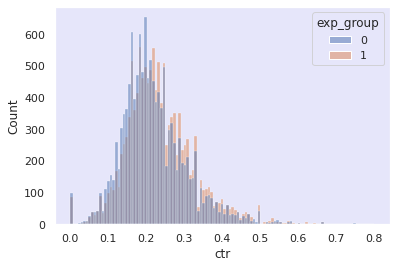

In [2]:
sns.histplot(data=df, x='ctr', hue='exp_group');
df.groupby('exp_group')['ctr'].agg(['mean', 'median'])

Визуально распределение CTR в экспериментальной группе смещено вправо по сравнению с контрольной группой.
Средняя и медиана тоже различаются, что необходимо проверить статистически. </br>

#### Сформируем гипотезы
H0: CTR контрольной группы и CTR эспериментальной группы не различаются </br>
H1: CTR контрольной группы и CTR эспериментальной группы различаются </br>

#### 1.1. t-test

In [3]:
print('t-test')
stats.ttest_ind(group_a, group_b, equal_var=False) # Welch’s t-test 

t-test


Ttest_indResult(statistic=-13.161495251257872, pvalue=1.9549052172618182e-39)

Отклоняем нулевую гипотезу, p-value ниже установленного alpha. Принимаем альтернативную гипотезу. Разница CTR статистически значима

#### 1.2. Mann-Whitney U test

In [4]:
print('Mann-Whitney U test')
stats.mannwhitneyu(group_a, group_b)

Mann-Whitney U test


MannwhitneyuResult(statistic=75455846.5, pvalue=1.9103112530392059e-50)

Отклоняем нулевую гипотезу, p-value ниже установленного alpha. Принимаем альтернативную гипотезу.
Разница CTR статистически значима

#### 1.3. Bootstrap

In [5]:
def get_bootstrap_ci_ctr(df, num_experiments=1000, alpha=0.05):
    '''
    Функция считает доверительный интервал CTR (двусторонний) при помощи бутстрэпа.
    ---
    Параметры:
        df               -- датафрейм
        num_experiments  -- количество экспериментов в симуляции
        alpha            -- уровень значимости  
    
    '''
    # формируем выборку CTR
    global_ctr_data = []
    for i in range(num_experiments):
        sample = df.sample(frac=0.5, replace=True)
        global_ctr = sample['likes'].sum() / sample['views'].sum()
        global_ctr_data.append(global_ctr)
    
    # рассчитываем границы доварительного интервала
    ci = np.percentile(global_ctr_data, [100 * alpha / 2.0, 100 * (1 - alpha / 2.0)])
    
    return ci

# устанавливаем уровень значимости
alpha=0.05

# рассчитываем доверительный интервал для контрольной группы
a_low, a_high = get_bootstrap_ci_ctr(
    df[df['exp_group']==0], num_experiments=1000, alpha=alpha)
message_a = f'{(1-alpha):.2f} доверительный интервал CTR для контрольной группы составляет [{a_low:.3f}; {a_high:.3f}]'

# рассчитываем доверительный интервал для экспериментальной группы
b_low, b_high = get_bootstrap_ci_ctr(
    df[df['exp_group']==1], num_experiments=1000, alpha=alpha)
message_b = f'{(1-alpha):.2f} доверительный интервал CTR для экспериментальной группы составляет [{b_low:.3f}; {b_high:.3f}]'

print(message_a)
print(message_b)

0.95 доверительный интервал CTR для контрольной группы составляет [0.211; 0.215]
0.95 доверительный интервал CTR для экспериментальной группы составляет [0.228; 0.232]


Доверительный интервал CTR контрольной группы и доверительный интервал CTR для экспериментальной группы не пересекаются. Отклоняем нулевую гипотезу и принимаем альтернативную гипотезу. Разница CTR статистически значима

### 2. Контрольная проверка просмотров
Проведем контрольную проверку, что новый алгоритм не привел к тому, что сократилось число просмотров у пользователей. Типичная ситуация в АB-тестах — вырастили число лайков, но уменьшили число просмотров.

Посмотрим на распределение просмотров в 2-х группах:

,min,median,max
exp_group,,,
0,1,51.0,366
1,1,51.0,362


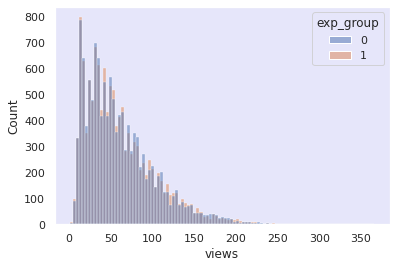

In [6]:
sns.histplot(data=df, x='views', hue='exp_group');
df.groupby('exp_group')['views'].agg(['min', 'median', 'max'])

Визуально распределение просмотров в экспериментальной группе похоже на распределение просмотров в контрольной группе. </br>

#### Сформируем гипотезы
H0: Просмотры контрольной группы и просмотры эспериментальной группы не различаются </br>
H1: Просмотры контрольной группы и просмотры эспериментальной группы различаются </br>

#### 2.1. t-test

In [7]:
print('t-test')
stats.ttest_ind(
    np.log(df.loc[df['exp_group']==0, 'views'].values), 
    np.log(df.loc[df['exp_group']==1, 'views'].values), 
    equal_var=False) # Welch’s t-test 

t-test


Ttest_indResult(statistic=0.21340400193402262, pvalue=0.8310135327751322)

Принимаем нулевую гипотезу, p-value выше установленного alpha. Разница в просмотрах статистически незначима.

####  2.2. Bootstrap

In [8]:
def get_bootstrap_ci_views(df, num_experiments=1000, alpha=0.05):
    '''
    Функция считает доверительный интервал CTR (двусторонний) при помощи бутстрэпа.
    ---
    Параметры:
        df               -- датафрейм
        num_experiments  -- количество экспериментов в симуляции
        alpha            -- уровень значимости  
    
    '''
    # формируем выборку CTR
    global_views_data = []
    for i in range(num_experiments):
        sample = df.sample(frac=0.5, replace=True)
        global_views = sample['views'].mean()
        global_views_data.append(global_views)
    
    # рассчитываем границы доварительного интервала
    ci = np.percentile(global_views_data, [100 * alpha / 2.0, 100 * (1 - alpha / 2.0)])
    
    return ci

# устанавливаем уровень значимости
alpha=0.05

# рассчитываем доверительный интервал для контрольной группы
a_low, a_high = get_bootstrap_ci_views(
    df[df['exp_group']==0], num_experiments=1000, alpha=alpha)
message_a = f'{(1-alpha):.2f} доверительный интервал просмотров для контрольной группы составляет [{a_low:.3f}; {a_high:.3f}]'

# рассчитываем доверительный интервал для экспериментальной группы
b_low, b_high = get_bootstrap_ci_views(
    df[df['exp_group']==1], num_experiments=1000, alpha=alpha)
message_b = f'{(1-alpha):.2f} доверительный интервал просмотров для экспериментальной группы составляет [{b_low:.3f}; {b_high:.3f}]'

print(message_a)
print(message_b)

0.95 доверительный интервал просмотров для контрольной группы составляет [60.255; 62.224]
0.95 доверительный интервал просмотров для экспериментальной группы составляет [60.207; 62.211]


Доверительный интервал просмотров контрольной группы и доверительный интервал просмотров для экспериментальной группы пересекаются. Принимаем нулевую гипотезу. Разница в просмотрах статистически незначима.

### 3. Рекомендации

Рекомендация основана на статистически значимых результатах AB-теста, проведенного с 2021-12-29 по 2022-01-04 включительно. 
- Гипотеза, что новый алгоритм в 1й группе приведет к увеличению CTR, подтвердилась
- Изменение алгоритма не привело к статистически значимому изменению в просмотрах
- Медианное значение CTR увеличилось с 0.2083 до 0.2241, что является материальным изменением

**Рекомендация:** раскатать новый алгоритм на всех новых пользователей.